In [111]:
import pandas as pd

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
#pd.set_option('display.max_colwidth', -1)  # or 199
pd.set_option('float_format', '{:,.2f}'.format)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from mlxtend.plotting import plot_decision_regions

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from collections import Counter

In [112]:
df = pd.read_pickle('Dataset.pkl')

In [113]:
df = df.query("Grupo == 'M-40 - Sistemas de distribuição e condicionamento, equipamentos e componentes' &\
         OPPORT_TYPE_JULGAMENTO=='ITEM' &\
         DM_CARACTERISTICA=='VENCEDOR PELA MELHOR PROPOSTA' & \
         SUB_STATUS != 4")

In [114]:
df.shape

(21516, 118)

In [115]:
df = df.drop(df.query("OUTLIER_IQR_UL or OUTLIER_IQR_LL").index)

In [116]:
df.shape

(19984, 118)

In [117]:
colunas_a_remover = [ 'OPPORT_TYPE', 'CURRENCY', 'MEPP_x', 'GROUPING_LEVEL', 'LOTE', 'TOTAL', 'Segmento', 'Escopo', 'Tipo',
 'CREATED_AT_DATE', 'CREATED_AT_TIME', 'NUMBER_INT', 'TZONE', 'MESSAGES', 'DESCRIPTION', 'OPPORT_NUM', 'QUANTITY_x', 'YPFAMITEM', 'ORDERED_PROD',
 'CHARACTERISTIC', 'STATUS', 'SUPPLIER_NAME', 'DESCRIPTION_UC', 'UNIT', 'DOU_PUBL_DATE', 'DIVULG_DATE_YPCON_DATE_H','RECURSAL_PERIOD','CREATED_AT_DATE_H',
 'END_DATE_H','COMMERCIAL_PROP_OPEN_DATE_H', 'ddd1','telefone1','ddd2','telefone2','ddd_fax','fax','correio_eletronico','situacao_especial',
'data_situacao_especial','cnae_fiscal_secundario','tipo_lograd','lograd','numero','complemento','bairro','cep','data_sit_cadastral','motivo_sit_cadastral',
'nome_cid_exterior','pais','nome_fantasia','ente_fed_resp','razao_social','TAXNUM','cnpj_dv','cnpj_ordem','cnpj_basico','START_DATE_H','DELIV_DATE',
'END_DATE_H_MES','START_DATE','municipio','QUANTITY_y','TOTAL_VALUE','UNIT_VALUE','Variação_DIA','Variação_%_DIA','Abertura_DIA','Máxima_DIA','Mínima_DIA',
'Volume_DIA','TEMPO_ABERTO','VARIACAO_COTACAO_MINERIO_FERRO_MES','OUTLIER_IQR_UL','OUTLIER_IQR_LL','Chave','calc_upper_limit','calc_lower_limit','Grupo',
'cnpj','len','AUC_START_DATE_H','YPCON_MODALITY','YPCON_MODALITY_NAME']
df.drop(colunas_a_remover, axis='columns', inplace=True)

In [118]:
from numpy import int8
df['target'] = df['target'].astype(int8)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 56 to 98373
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype          
---  ------                                     --------------  -----          
 0   natureza_jur                               19984 non-null  object         
 1   quali_resp                                 19984 non-null  object         
 2   capital_social                             19984 non-null  float64        
 3   porte                                      19984 non-null  object         
 4   quantidade_estabelecimentos_grupo          19984 non-null  int64          
 5   id_matriz_filial                           19984 non-null  object         
 6   sit_cadastral                              19984 non-null  object         
 7   cnae_fiscal_principal                      19984 non-null  object         
 8   uf                                         19984 non-null  object         
 9   idade

In [120]:
#df.drop(['VARIACAO_COTACAO_MINERIO_FERRO_MES'],axis=1, inplace=True)

In [121]:
from numpy import int64

df['TEMPO_DURACAO'] = df['TEMPO_DURACAO'].astype(int64)
df['TEMPO_RECURSO'] = df['TEMPO_RECURSO'].astype(int64)

Text(0.5, 1.0, 'Valores Faltantes')

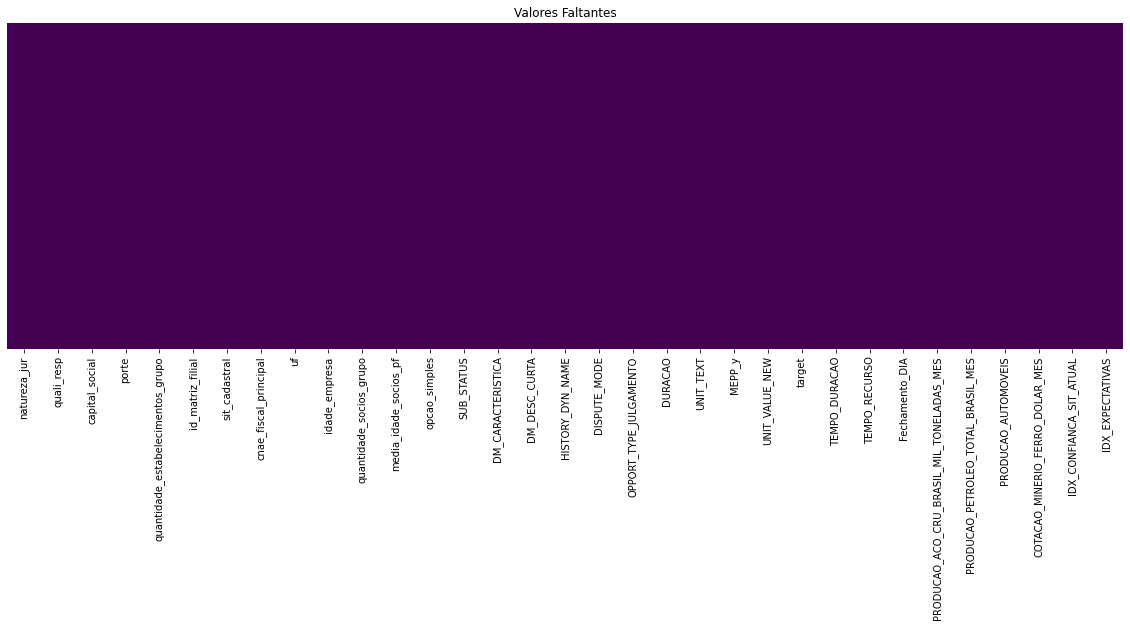

In [122]:
plt.figure(figsize=(20,6))
sns.heatmap(df.isna(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Valores Faltantes')

<AxesSubplot:>

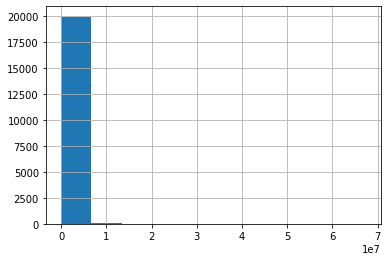

In [123]:
df['UNIT_VALUE_NEW'].hist()

<AxesSubplot:>

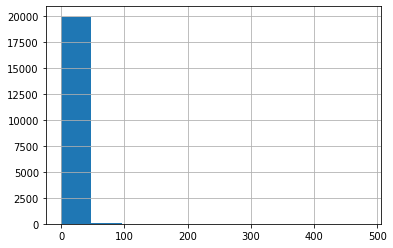

In [124]:
from sklearn.preprocessing import RobustScaler
# Create a RobustScaler object
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df[['UNIT_VALUE_NEW']])
df.drop(['UNIT_VALUE_NEW'], axis=1, inplace=True)
df['UNIT_VALUE_NEW_scaled'] = pd.Series(scaled_values.reshape(-1), index=df.index)
df['UNIT_VALUE_NEW_scaled'].hist()

In [125]:
lista_scaler = df.select_dtypes(['int64','float64']).columns.to_list()
lista_scaler

for idx,item in enumerate(lista_scaler):
    if not(item in ['target','target_v2','UNIT_VALUE_NEW_scaled']):
        # Create a RobustScaler object
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[[f'{item}']])
        df.drop([f'{item}'], axis=1, inplace=True)
        df[f'{item}_scaled'] = pd.Series(scaled_values.reshape(-1), index=df.index)         

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 56 to 98373
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   natureza_jur                                      19984 non-null  object 
 1   quali_resp                                        19984 non-null  object 
 2   porte                                             19984 non-null  object 
 3   id_matriz_filial                                  19984 non-null  object 
 4   sit_cadastral                                     19984 non-null  object 
 5   cnae_fiscal_principal                             19984 non-null  object 
 6   uf                                                19984 non-null  object 
 7   opcao_simples                                     19984 non-null  object 
 8   SUB_STATUS                                        19984 non-null  string 
 9   DM_CARACTERISTIC

<AxesSubplot:>

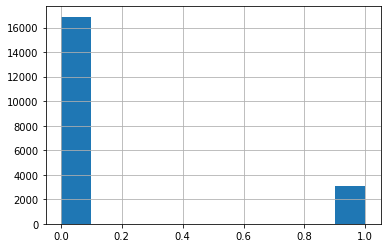

In [128]:
df['target'].hist()

In [129]:
df['target'].unique()

array([0, 1], dtype=int8)

<AxesSubplot:>

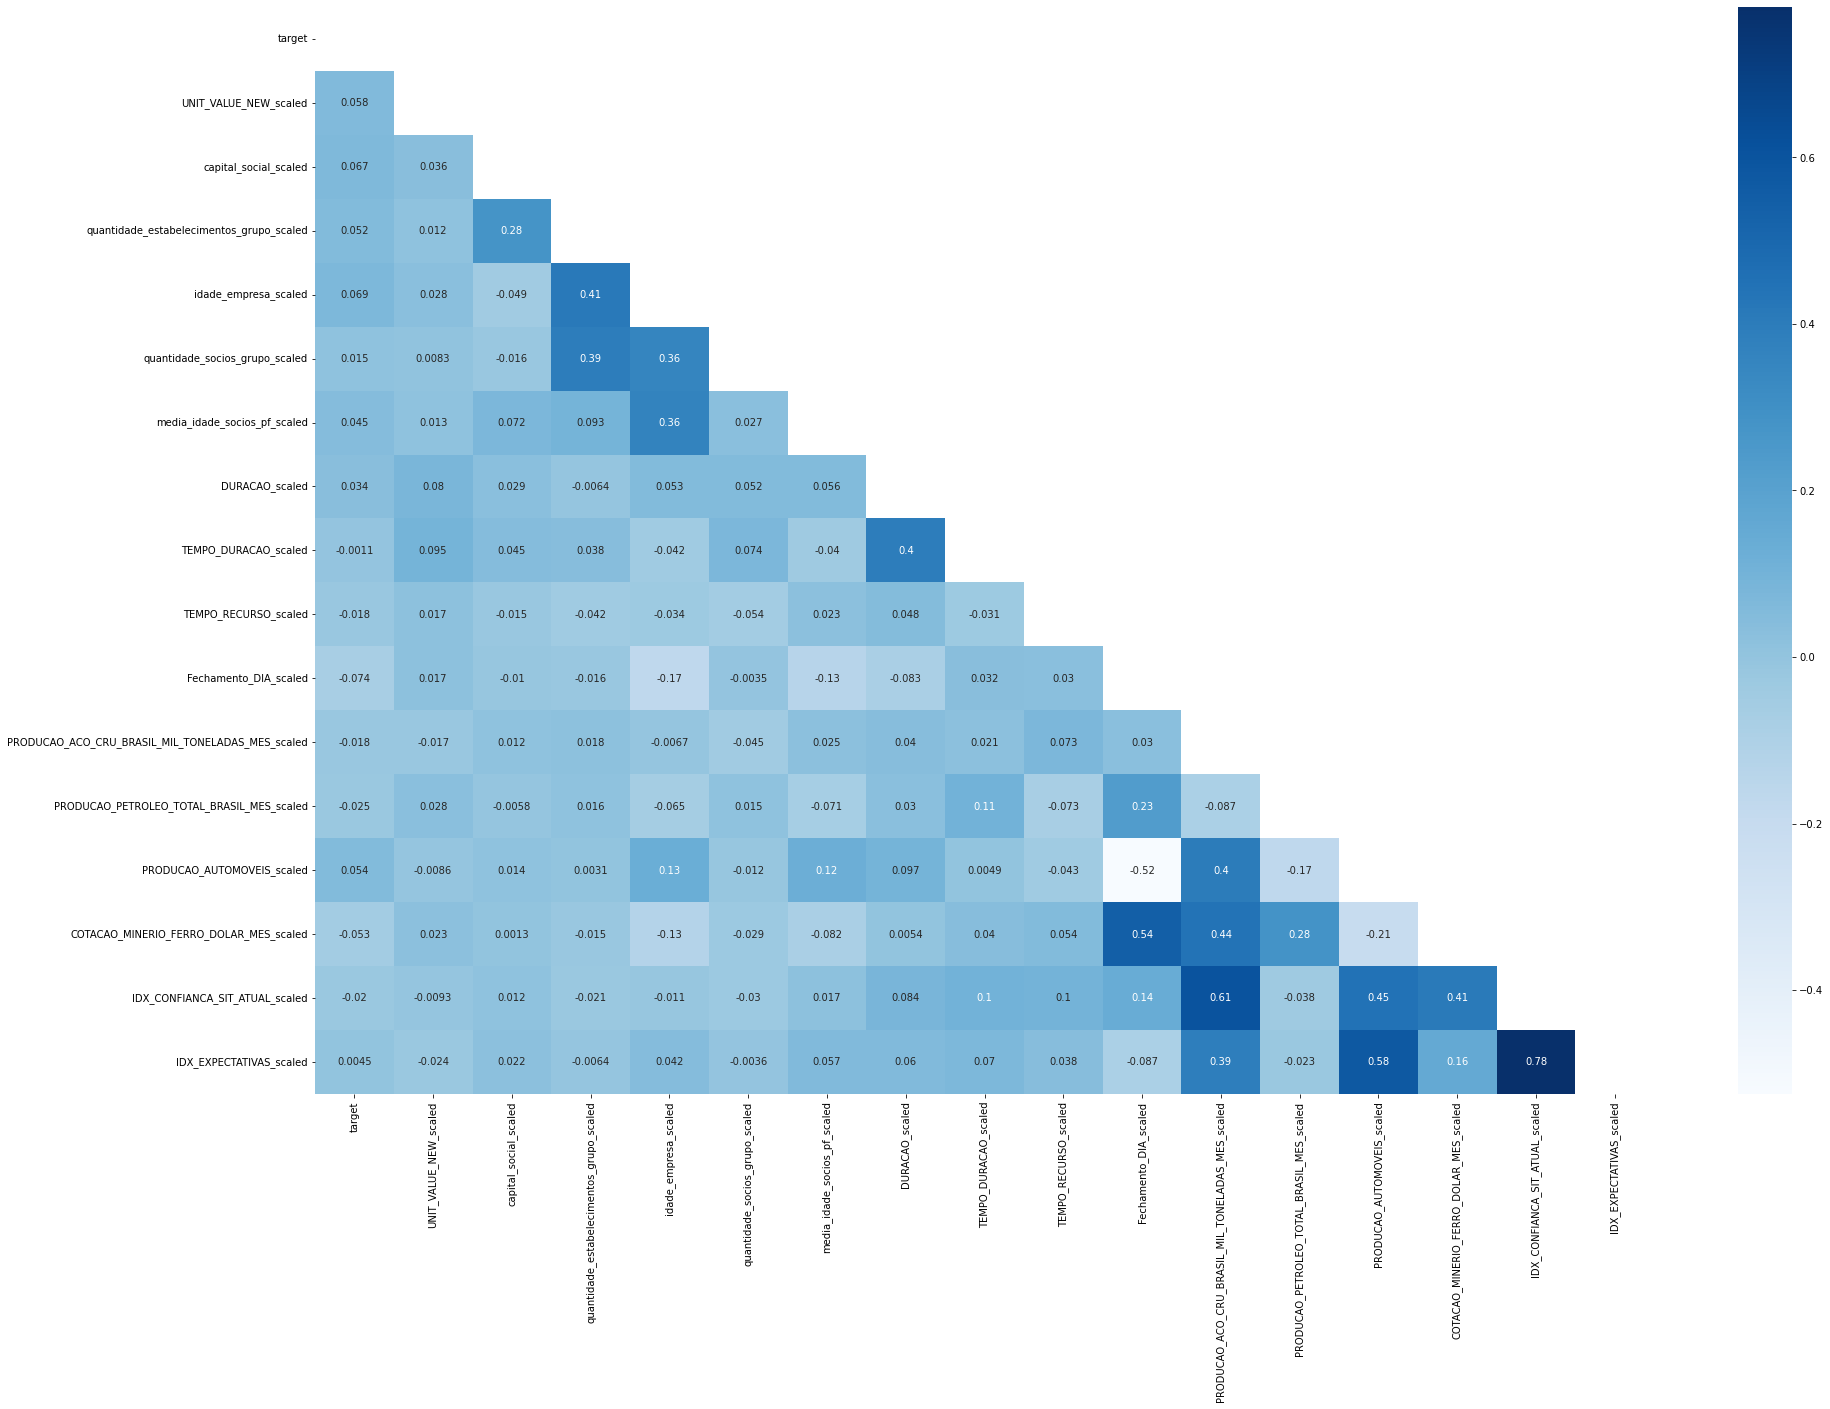

In [130]:
import matplotlib.pyplot as plt
# creating mask

# correlation plot
corr = df.corr()
mask = np.triu(np.ones_like(corr),)
fig, ax = plt.subplots(figsize=(30,20))         # Sample figsize in inches
sns.heatmap(corr, cmap = 'Blues', annot= True, mask=mask)

In [131]:
df.drop(['DURACAO_scaled','IDX_EXPECTATIVAS_scaled'], axis='columns', inplace=True)

<AxesSubplot:>

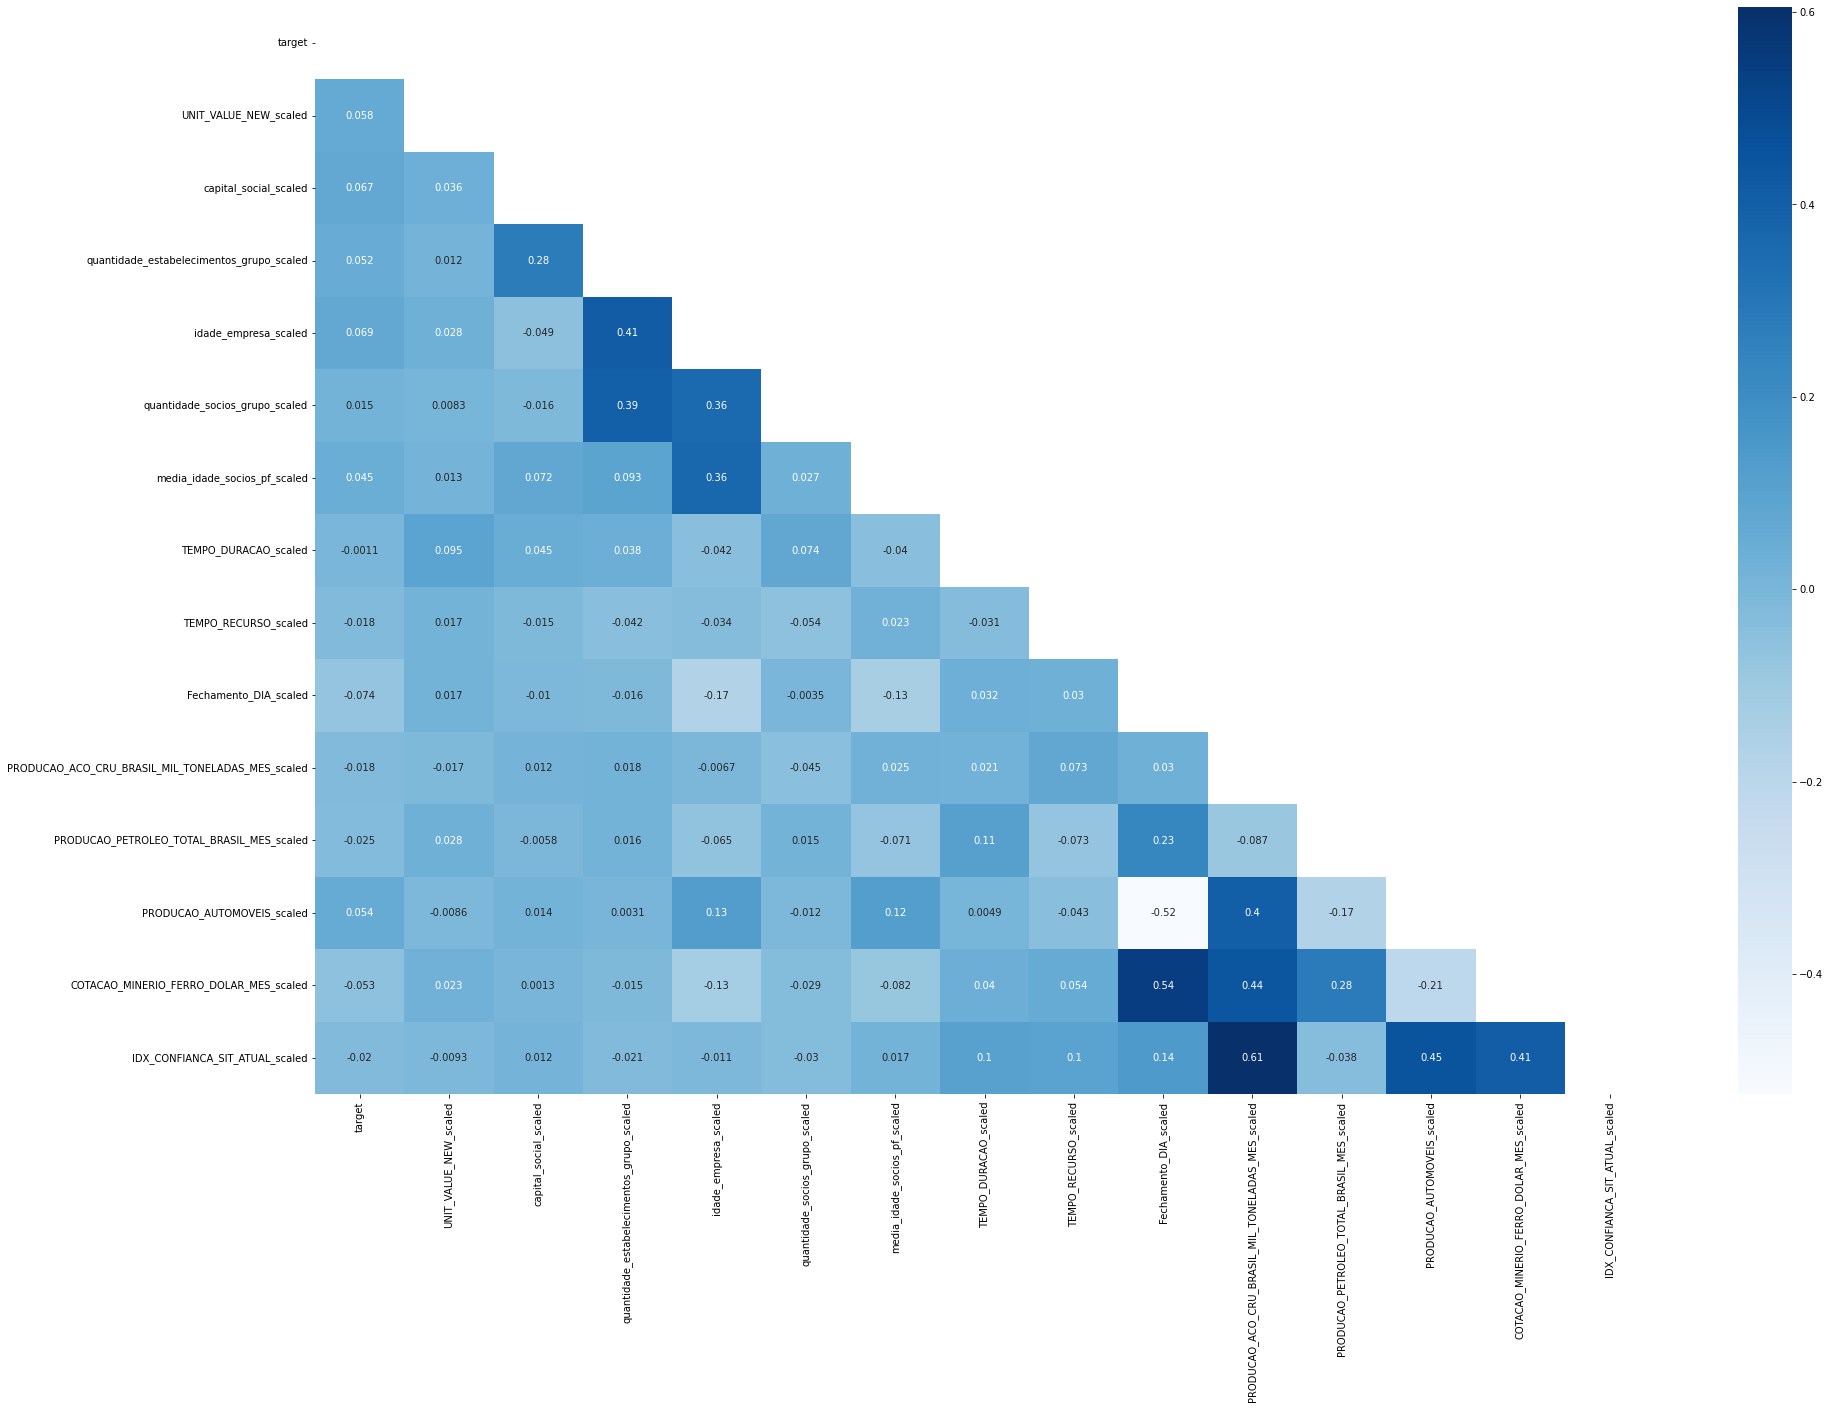

In [132]:
import matplotlib.pyplot as plt

# correlation plot
corr = df.corr()
mask = np.triu(np.ones_like(corr),)
fig, ax = plt.subplots(figsize=(30,20))         # Sample figsize in inches
sns.heatmap(corr, cmap = 'Blues', annot= True, mask=mask)

In [133]:
df.drop(['COTACAO_MINERIO_FERRO_DOLAR_MES_scaled'], axis='columns', inplace=True)

<AxesSubplot:>

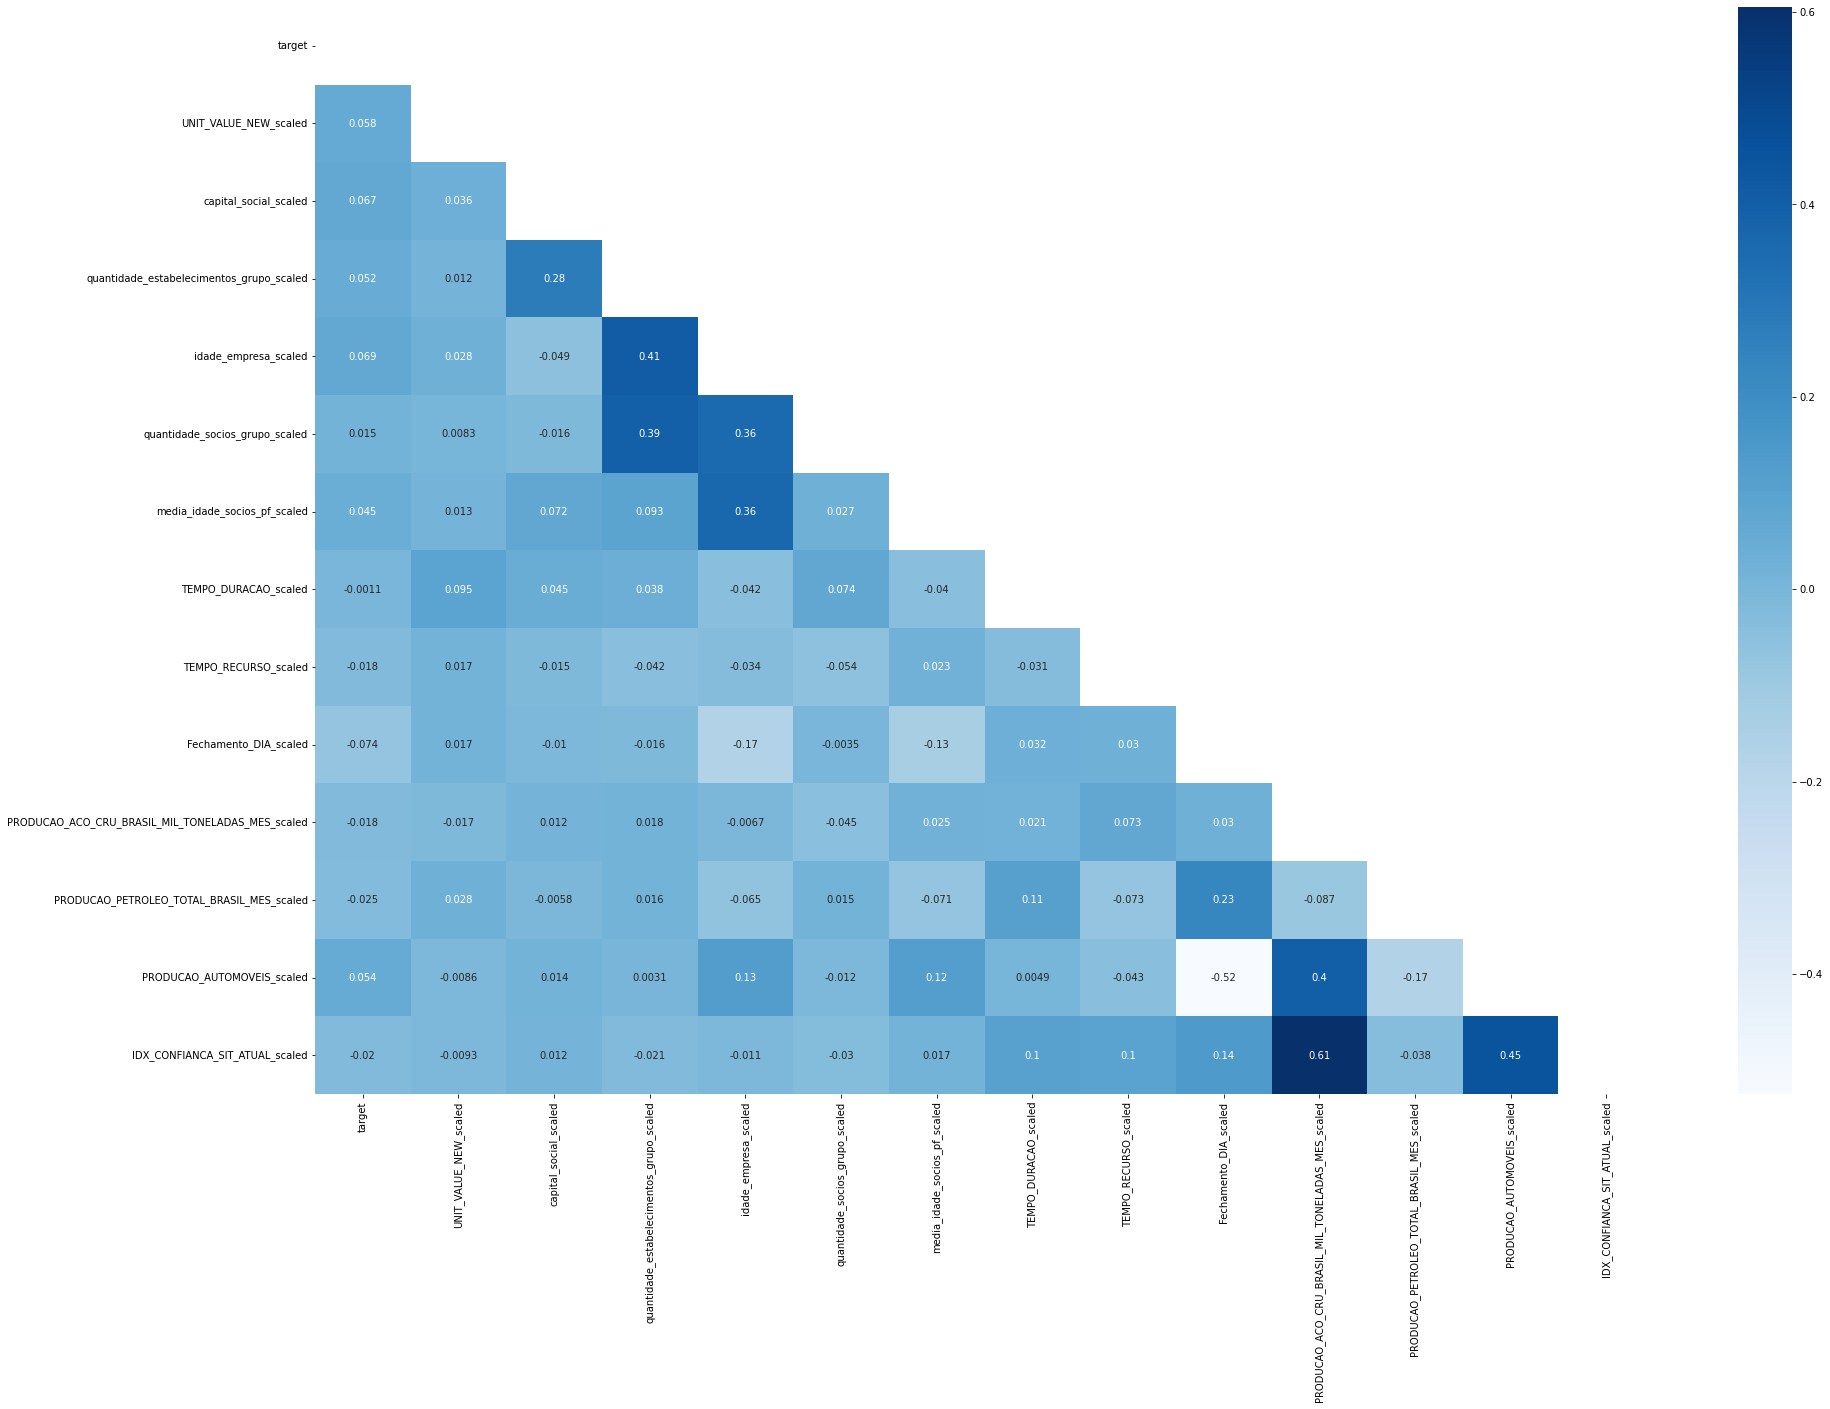

In [134]:
import matplotlib.pyplot as plt

# correlation plot
corr = df.corr()
mask = np.triu(np.ones_like(corr),)
fig, ax = plt.subplots(figsize=(30,20))         # Sample figsize in inches
sns.heatmap(corr, cmap = 'Blues', annot= True, mask=mask)

<AxesSubplot:>

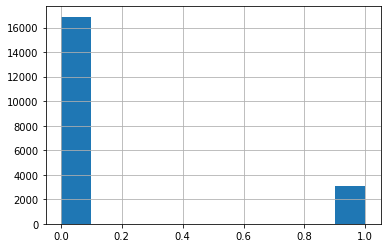

In [135]:
df.target.hist()

In [136]:
df_colunas_obj = df.loc[:, df.dtypes == object]
cols_object = df_colunas_obj.describe().T
cols_object = cols_object.reset_index()
cols_object['dist_uniques'] = (cols_object['freq'] / cols_object['count'])*100
cols_object.sort_values('unique')

,index,count,unique,top,freq,dist_uniques
8,DM_CARACTERISTICA,19984,1,VENCEDOR PELA MELHOR PROPOSTA,19984,100.00
9,DM_DESC_CURTA,19984,1,ENVELOPE,19984,100.00
10,HISTORY_DYN_NAME,19984,1,Historic,19984,100.00
11,DISPUTE_MODE,19984,1,2 - MODO DE DISPUTA FECHADO,19984,100.00
12,OPPORT_TYPE_JULGAMENTO,19984,1,ITEM,19984,100.00
3,id_matriz_filial,19984,2,Matriz,18082,90.48
7,opcao_simples,19984,2,N,19671,98.43
14,MEPP_y,19984,2,0,14134,70.73
2,porte,19984,3,Demais,14174,70.93
4,sit_cadastral,19984,3,Ativa,19904,99.60


In [137]:
df.drop(['SUB_STATUS','DM_CARACTERISTICA','DM_DESC_CURTA','HISTORY_DYN_NAME','DISPUTE_MODE','OPPORT_TYPE_JULGAMENTO'], axis='columns', inplace=True)

In [138]:
one_hot_encoding_columns = df.describe(include='O').T.reset_index()['index'].to_list()
one_hot_encoding_columns


['natureza_jur',
 'quali_resp',
 'porte',
 'id_matriz_filial',
 'sit_cadastral',
 'cnae_fiscal_principal',
 'uf',
 'opcao_simples',
 'UNIT_TEXT',
 'MEPP_y']

In [139]:
prefix = dict(zip(one_hot_encoding_columns, one_hot_encoding_columns))
prefix
print(prefix)

{'natureza_jur': 'natureza_jur', 'quali_resp': 'quali_resp', 'porte': 'porte', 'id_matriz_filial': 'id_matriz_filial', 'sit_cadastral': 'sit_cadastral', 'cnae_fiscal_principal': 'cnae_fiscal_principal', 'uf': 'uf', 'opcao_simples': 'opcao_simples', 'UNIT_TEXT': 'UNIT_TEXT', 'MEPP_y': 'MEPP_y'}


In [141]:
# Dummy variable
df = pd.get_dummies(data = df, prefix = prefix, prefix_sep='_',
               columns = one_hot_encoding_columns,
               drop_first =True,
              dtype='int8')

In [143]:
df.to_pickle('BASE PREPARADA MODELO.pkl')